In [87]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Define the RBF kernel function
def rbf_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y, axis=1) ** 2 / (2 * sigma ** 2))

# Compute the kernel matrix
def compute_kernel_matrix(X, sigma=1.0):
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        K[i, :] = rbf_kernel(X, X[i], sigma)
    return K

# Train Kernel Ridge Regression
def train_krr(X, y, sigma=1.0, lambd=1.0):
    K = compute_kernel_matrix(X, sigma)
    n_samples = X.shape[0]
    # Regularization term: lambda * I
    alpha = np.linalg.inv(K + lambd * np.eye(n_samples)).dot(y)
    return alpha

# Prediction function for Kernel Ridge Regression
def predict_krr(X_train, X_test, alpha, sigma=1.0):
    n_test_samples = X_test.shape[0]
    predictions = np.zeros(n_test_samples)
    for i in range(n_test_samples):
        k = rbf_kernel(X_train, X_test[i], sigma)
        predictions[i] = k.dot(alpha)
    return predictions

def predictive_covariance_krr(X_train, X_test, alpha, sigma=1.0, lambd=1.0):
    # Compute kernel matrix K between test points and training points
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    K_test_train = np.zeros((n_test, n_train))
    for i in range(n_test):
        K_test_train[i, :] = rbf_kernel(X_train, X_test[i], sigma)

    # Compute kernel matrix K among training points
    K_train = compute_kernel_matrix(X_train, sigma)
    
    # Compute the predictive mean using the alpha values
    predictive_mean = K_test_train.dot(alpha)

    # Calculate the covariance matrix for the predictions
    # C = K(X_test, X_test) - K_test_train * (K_train + lambd * I)^-1 * K_test_train.T
    K_test = compute_kernel_matrix(X_test, sigma)
    K_train_inv = np.linalg.inv(K_train + lambd * np.eye(n_train))
    predictive_covariance = K_test - K_test_train.dot(K_train_inv).dot(K_test_train.T)

    return predictive_mean, predictive_covariance


# Example usage
def f(x):
    return np.sin(2 * np.pi * x).ravel()

X = np.random.rand(20,1)  # Training data on the unit interval
y = f(X) + np.random.randn(len(X))*.1 # Some function over the interval

# Train the model
alpha = train_krr(X, y, sigma=0.1, lambd=0.01)



In [88]:
def plot_stuff(X,X_grid,alpha):
    # Predict using the model
    X_grid = np.linspace(0, 1, 100).reshape(-1, 1)  # Test data
    # mu_grid = predict_krr(X, X_grid, alpha, sigma=0.1)
    mu_grid, Sigma_grid = predictive_covariance_krr(X, X_grid, alpha, sigma=0.1)

    # Plot predicted function with confidence bound
    plt.figure(1)
    plt.plot(X_grid, f(X_grid), label='True f')
    plt.plot(X, y,'o',label='Observations')
    plt.plot(X_grid, mu_grid, label='Predicted f', color='green')
    plt.fill_between(X_grid.squeeze(1), mu_grid- np.sqrt(np.diagonal(Sigma_grid)), mu_grid+ np.sqrt(np.diagonal(Sigma_grid)), alpha=0.2, label='1 std', color='green')
    plt.ylim((-2,2))
    plt.legend()

    # Plot posterior samples 
    plt.figure(2)
    Sigma_grid_sqrt = np.real(scipy.linalg.sqrtm(Sigma_grid))
    plt.plot(X_grid, f(X_grid), label='True f')
    plt.plot(X, y,'o',label='Observations')

    for k in range(10):
        sample =  mu_grid + Sigma_grid_sqrt @ np.random.randn(len(mu_grid)) 
        if k ==0: plt.plot(X_grid, sample, label='Posterior sample', color='k', linewidth=.25)
        plt.plot(X_grid, sample, color='k', linewidth=.25)
    plt.ylim((-2,2))
    plt.legend()
    

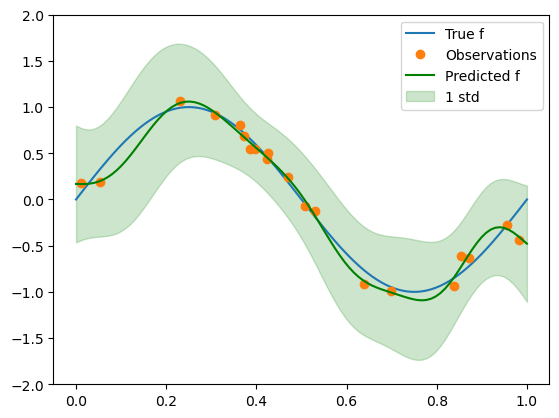

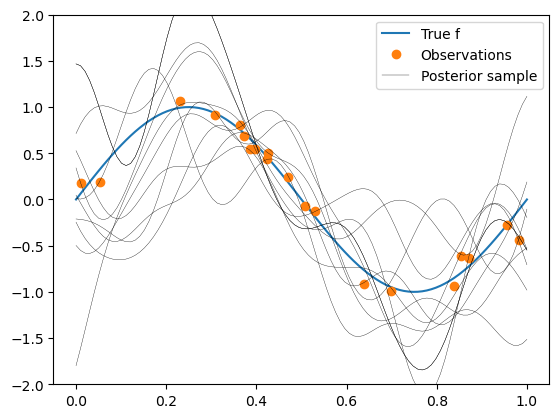

In [89]:
plot_stuff(X,X_grid,alpha)

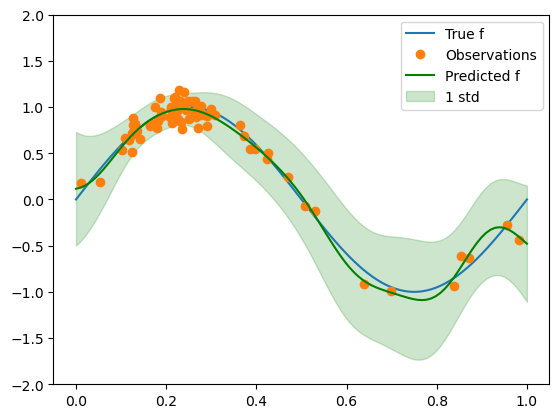

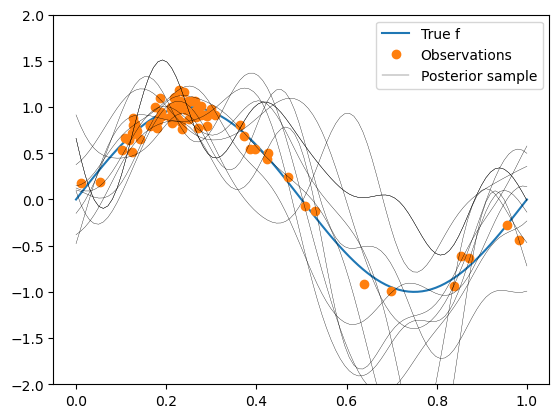

In [90]:
X_new = np.random.rand(60,1)*.2 + .1
X = np.concatenate((X,X_new),axis=0)
y_new = f(X_new) + np.random.randn(len(X_new))*.1 # Some function over the interval
y = np.concatenate((y,y_new),axis=0)
alpha = train_krr(X, y, sigma=0.1, lambd=0.01)

plot_stuff(X,X_grid,alpha)